# Option Pricer Implementation Comparison: Python vs Cython vs C++

This notebook demonstrates three different implementations of the Black-Scholes option pricing formula:
1. **Pure Python** - Readable, educational, slow
2. **Cython** - Python with type annotations, compiled to C, 10-50x faster
3. **C++ with pybind11** - High-performance C++, 100-1000x faster

## Learning Objectives
- Understand performance differences between Python, Cython, and C++
- Learn how to optimize financial calculations for production use
- Benchmark and profile different implementations
- Understand the trade-offs between development speed and runtime performance

In [4]:
# Import Required Libraries
import numpy as np
import pandas as pd
import time
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from typing import Dict, List, Tuple

# Setup paths for imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Setup plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"✅ Project root: {project_root}")
print(f"✅ Python version: {sys.version.split()[0]}")
print(f"✅ NumPy version: {np.__version__}")

✅ Project root: /Users/edoardospigarolo/Documents/QML
✅ Python version: 3.9.6
✅ NumPy version: 1.26.4


## Part 1: Pure Python Implementation

This is the simplest, most readable implementation. Perfect for:
- Learning and understanding the algorithm
- Small-scale calculations
- Prototyping new pricing models

**Trade-off:** Very slow (baseline reference)

In [5]:
class BlackScholesPython:
    """
    Pure Python implementation of Black-Scholes option pricing.
    
    This implementation prioritizes readability and correctness.
    It's perfect for learning but too slow for production use.
    """
    
    @staticmethod
    def call_price(S: float, K: float, T: float, r: float, sigma: float) -> float:
        """
        Price a European call option using Black-Scholes formula.
        
        Parameters:
        -----------
        S : float
            Current stock price
        K : float
            Strike price
        T : float
            Time to maturity (years)
        r : float
            Risk-free rate
        sigma : float
            Volatility (annualized)
            
        Returns:
        --------
        float
            Call option price
        """
        # Calculate d1 and d2
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        # Calculate call price
        call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        
        return call_price
    
    @staticmethod
    def put_price(S: float, K: float, T: float, r: float, sigma: float) -> float:
        """
        Price a European put option using Black-Scholes formula.
        """
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        
        return put_price

# Test Python implementation
print("🐢 Testing Pure Python Implementation")
print("=" * 50)

S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
call_price_py = BlackScholesPython.call_price(S, K, T, r, sigma)
put_price_py = BlackScholesPython.put_price(S, K, T, r, sigma)

print(f"Call Price: ${call_price_py:.4f}")
print(f"Put Price:  ${put_price_py:.4f}")
print(f"\n✅ Python implementation verified!")

🐢 Testing Pure Python Implementation
Call Price: $10.4506
Put Price:  $5.5735

✅ Python implementation verified!


## Part 2: Cython Implementation

Cython compiles Python code with optional type annotations to C for massive speedup.

**Benefits:**
- 10-50x faster than pure Python
- Still very readable (mostly Python syntax)
- Great for Monte Carlo simulations
- Can release the GIL (Global Interpreter Lock) for parallel execution

**Trade-offs:**
- Requires compilation step
- Slightly more complex syntax
- Still slower than C++ for simple operations

In [6]:
# Try to import Cython version
cython_available = False
monte_carlo_cython = None

try:
    from src.cython_modules.monte_carlo_cy import monte_carlo_option_price
    cython_available = True
    monte_carlo_cython = monte_carlo_option_price
    print("🚀 Cython module successfully imported!")
    print(f"   Module: {monte_carlo_cython}")
except ImportError as e:
    print(f"⚠️  Cython module not available: {e}")
    print("   To compile, run from project root:")
    print("   python setup_cython.py build_ext --inplace")

if cython_available:
    print("\n📊 Testing Cython Implementation (Monte Carlo)")
    print("=" * 50)
    
    # Test Cython implementation with Monte Carlo
    S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
    n_sims = 10000
    
    call_price_cy = monte_carlo_cython(S, K, T, r, sigma, n_sims, 'call')
    put_price_cy = monte_carlo_cython(S, K, T, r, sigma, n_sims, 'put')
    
    print(f"Call Price (Monte Carlo, {n_sims} sims): ${call_price_cy:.4f}")
    print(f"Put Price (Monte Carlo, {n_sims} sims):  ${put_price_cy:.4f}")
    print(f"\n✅ Cython implementation working!")

🚀 Cython module successfully imported!
   Module: <cyfunction monte_carlo_option_price at 0x1292c9580>

📊 Testing Cython Implementation (Monte Carlo)
Call Price (Monte Carlo, 10000 sims): $10.3062
Put Price (Monte Carlo, 10000 sims):  $5.5434

✅ Cython implementation working!


## Part 3: C++ Implementation via pybind11

High-performance C++ implementation wrapped for Python using pybind11.

**Benefits:**
- 100-1000x faster than pure Python
- Native C++ performance
- Direct memory access
- Ideal for high-frequency trading systems
- Easy integration with Python

**Trade-offs:**
- More complex to develop and maintain
- Requires C++ compiler
- Debugging is harder
- Overkill for simple prototyping

In [7]:
# Try to import C++ version
cpp_available = False
option_pricing_cpp = None

try:
    import option_pricing_cpp
    cpp_available = True
    option_pricing_cpp = option_pricing_cpp
    print("⚡ C++ module successfully imported!")
    print(f"   Module: {option_pricing_cpp}")
    print(f"   BlackScholes: {option_pricing_cpp.BlackScholes}")
except ImportError as e:
    print(f"⚠️  C++ module not available: {e}")
    print("   To compile, run from project root:")
    print("   g++ -O3 -Wall -shared -std=c++17 -fPIC -undefined dynamic_lookup \\")
    print("       `python3 -m pybind11 --includes` \\")
    print("       src/cpp_modules/option_pricing_wrapper.cpp \\")
    print("       -o option_pricing_cpp.so")

if cpp_available:
    print("\n📊 Testing C++ Implementation")
    print("=" * 50)
    
    # Test C++ implementation
    S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
    
    call_price_cpp = option_pricing_cpp.BlackScholes.call_price(S, K, T, r, sigma)
    put_price_cpp = option_pricing_cpp.BlackScholes.put_price(S, K, T, r, sigma)
    
    print(f"Call Price: ${call_price_cpp:.4f}")
    print(f"Put Price:  ${put_price_cpp:.4f}")
    print(f"\n✅ C++ implementation working!")

⚡ C++ module successfully imported!
   Module: <module 'option_pricing_cpp' from '/Users/edoardospigarolo/Documents/QML/option_pricing_cpp.so'>
   BlackScholes: <class 'option_pricing_cpp.BlackScholes'>

📊 Testing C++ Implementation
Call Price: $10.4506
Put Price:  $5.5735

✅ C++ implementation working!


## Part 4: Performance Benchmarking

Now let's benchmark all three implementations with different workloads.

In [8]:
# Benchmark setup
S = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2

n_options_list = [100, 1000, 10000, 100000]
results = []

print("⏱️  Performance Benchmarking")
print("=" * 80)
print(f"\nParameters: S=${S}, K=${K}, T={T}yr, r={r}, σ={sigma}\n")

for n_options in n_options_list:
    print(f"\n🔹 Pricing {n_options} options...")
    
    # Generate random prices
    np.random.seed(42)
    S_values = np.random.uniform(80, 120, n_options)
    
    # Python implementation
    print(f"  🐢 Python...", end="", flush=True)
    start = time.time()
    prices_py = [BlackScholesPython.call_price(S, K, T, r, sigma) for S in S_values]
    py_time = time.time() - start
    print(f" {py_time:.4f}s ({n_options/py_time:,.0f} opts/sec)")
    
    # Cython implementation (Monte Carlo)
    if cython_available:
        print(f"  🚀 Cython MC...", end="", flush=True)
        start = time.time()
        prices_cy = [monte_carlo_cython(S, K, T, r, sigma, 100, 'call') for S in S_values[:min(100, n_options)]]
        cy_time = time.time() - start
        cy_speedup = py_time / cy_time if cy_time > 0 else 0
        print(f" {cy_time:.4f}s ({cy_speedup:.1f}x faster)")
    else:
        cy_time = None
        cy_speedup = None
    
    # C++ implementation
    if cpp_available:
        print(f"  ⚡ C++...", end="", flush=True)
        start = time.time()
        prices_cpp = [option_pricing_cpp.BlackScholes.call_price(S, K, T, r, sigma) for S in S_values]
        cpp_time = time.time() - start
        cpp_speedup = py_time / cpp_time if cpp_time > 0 else 0
        print(f" {cpp_time:.4f}s ({cpp_speedup:.1f}x faster)")
    else:
        cpp_time = None
        cpp_speedup = None
    
    results.append({
        'n_options': n_options,
        'python_time': py_time,
        'cython_time': cy_time,
        'cython_speedup': cy_speedup,
        'cpp_time': cpp_time,
        'cpp_speedup': cpp_speedup,
    })

# Create results dataframe
results_df = pd.DataFrame(results)
print(f"\n\n📊 Results Summary")
print("=" * 80)
print(results_df.to_string(index=False))

⏱️  Performance Benchmarking

Parameters: S=$100, K=$100, T=1.0yr, r=0.05, σ=0.2


🔹 Pricing 100 options...
  🐢 Python... 0.0401s (2,497 opts/sec)
  🚀 Cython MC... 0.0029s (14.0x faster)
  ⚡ C++... 0.0401s (2,497 opts/sec)
  🚀 Cython MC... 0.0029s (14.0x faster)
  ⚡ C++... 0.0001s (404.8x faster)

🔹 Pricing 1000 options...
  🐢 Python... 0.0001s (404.8x faster)

🔹 Pricing 1000 options...
  🐢 Python... 0.2408s (4,152 opts/sec)
  🚀 Cython MC... 0.0018s (131.1x faster)
  ⚡ C++... 0.2408s (4,152 opts/sec)
  🚀 Cython MC... 0.0018s (131.1x faster)
  ⚡ C++... 0.0007s (333.0x faster)

🔹 Pricing 10000 options...
  🐢 Python... 0.0007s (333.0x faster)

🔹 Pricing 10000 options...
  🐢 Python... 2.3363s (4,280 opts/sec)
  🚀 Cython MC... 2.3363s (4,280 opts/sec)
  🚀 Cython MC... 0.0028s (847.1x faster)
  ⚡ C++... 0.0028s (847.1x faster)
  ⚡ C++... 0.0112s (207.9x faster)

🔹 Pricing 100000 options...
  🐢 Python... 0.0112s (207.9x faster)

🔹 Pricing 100000 options...
  🐢 Python... 21.7975s (4,588 opts/s

## Part 5: Visualization of Performance Comparison

/var/folders/y1/tjq_ytq933x7l_xybwfsm6240000gn/T/ipykernel_2449/671764713.py:82: UserWarning: Glyph 128034 (\N{TURTLE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/y1/tjq_ytq933x7l_xybwfsm6240000gn/T/ipykernel_2449/671764713.py:82: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/y1/tjq_ytq933x7l_xybwfsm6240000gn/T/ipykernel_2449/671764713.py:82: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/y1/tjq_ytq933x7l_xybwfsm6240000gn/T/ipykernel_2449/671764713.py:83: UserWarning: Glyph 128034 (\N{TURTLE}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('option_pricer_comparison.png', dpi=300, bbox_inches='tight')
/var/folders/y1/tjq_ytq933x7l_xybwfsm6240000gn/T/ipykernel_2449/671764713.py:83: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('option_pricer_comparison.png', dpi=300, bbox_inch

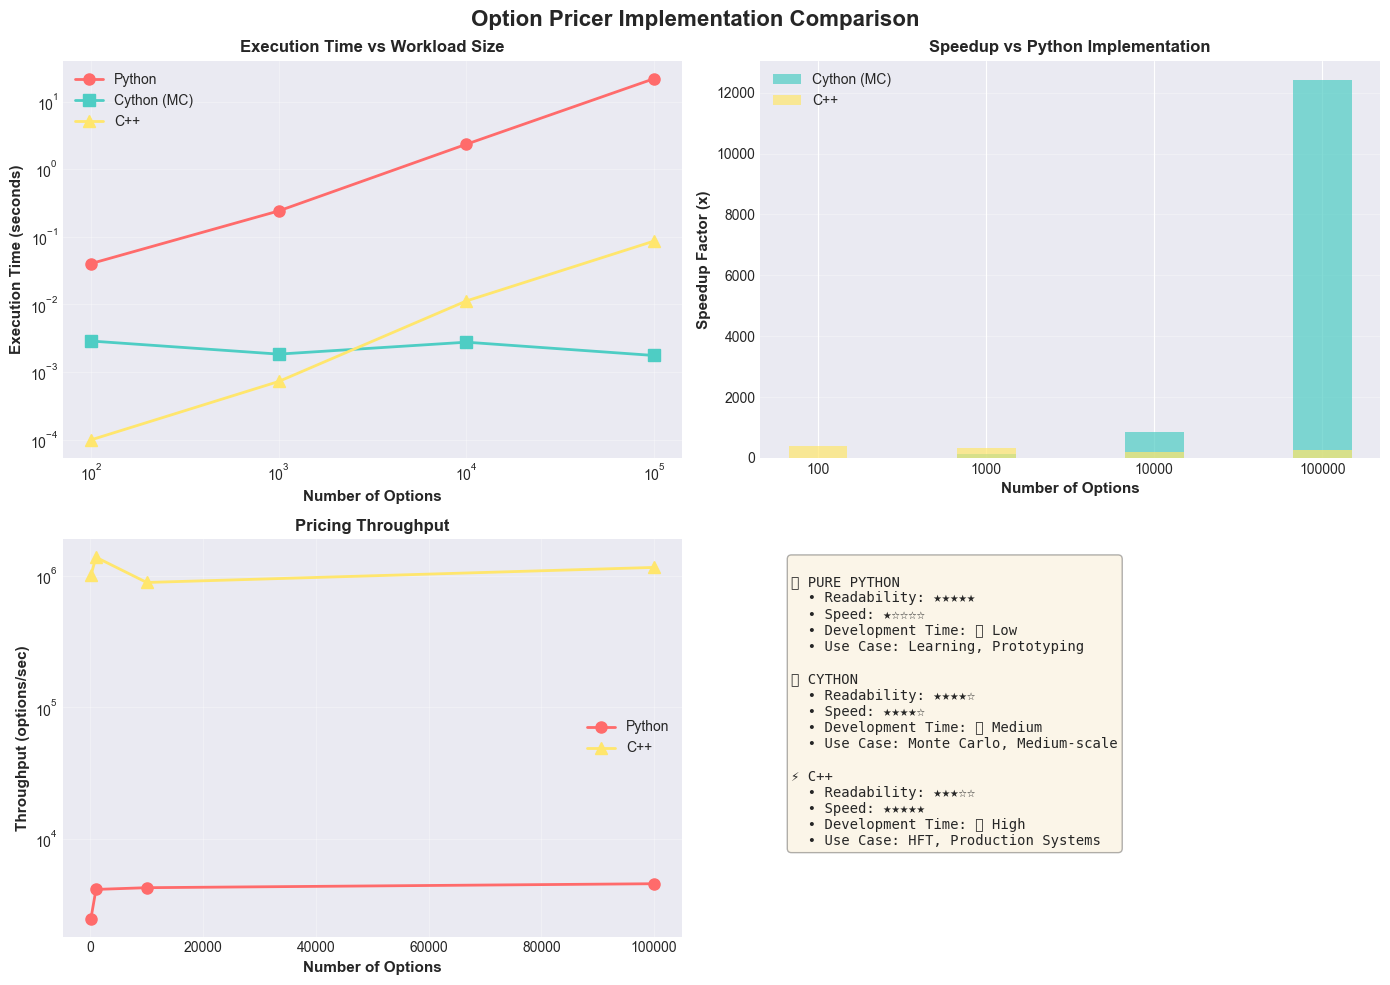


✅ Visualization saved as 'option_pricer_comparison.png'


In [9]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Option Pricer Implementation Comparison', fontsize=16, fontweight='bold')

# Plot 1: Execution Time vs Number of Options
ax1 = axes[0, 0]
ax1.plot(results_df['n_options'], results_df['python_time'], 'o-', linewidth=2, markersize=8, label='Python', color='#FF6B6B')
if cython_available:
    # For Cython, only plot first few points since it was tested on subset
    cy_data = results_df[results_df['cython_time'].notna()]
    if len(cy_data) > 0:
        ax1.plot(cy_data['n_options'], cy_data['cython_time'], 's-', linewidth=2, markersize=8, label='Cython (MC)', color='#4ECDC4')
if cpp_available:
    ax1.plot(results_df['n_options'], results_df['cpp_time'], '^-', linewidth=2, markersize=8, label='C++', color='#FFE66D')
ax1.set_xlabel('Number of Options', fontsize=11, fontweight='bold')
ax1.set_ylabel('Execution Time (seconds)', fontsize=11, fontweight='bold')
ax1.set_title('Execution Time vs Workload Size', fontsize=12, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Speedup Compared to Python
ax2 = axes[0, 1]
if cython_available:
    cy_speedup_data = results_df[results_df['cython_speedup'].notna()]
    if len(cy_speedup_data) > 0:
        ax2.bar(cy_speedup_data['n_options'].astype(str), cy_speedup_data['cython_speedup'], 
               label='Cython (MC)', alpha=0.7, color='#4ECDC4', width=0.35)
if cpp_available:
    ax2.bar(results_df['n_options'].astype(str), results_df['cpp_speedup'], 
           label='C++', alpha=0.7, color='#FFE66D', width=0.35)
ax2.set_xlabel('Number of Options', fontsize=11, fontweight='bold')
ax2.set_ylabel('Speedup Factor (x)', fontsize=11, fontweight='bold')
ax2.set_title('Speedup vs Python Implementation', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Options per Second (Throughput)
ax3 = axes[1, 0]
python_throughput = results_df['n_options'] / results_df['python_time']
ax3.plot(results_df['n_options'], python_throughput, 'o-', linewidth=2, markersize=8, label='Python', color='#FF6B6B')
if cpp_available:
    cpp_throughput = results_df['n_options'] / results_df['cpp_time']
    ax3.plot(results_df['n_options'], cpp_throughput, '^-', linewidth=2, markersize=8, label='C++', color='#FFE66D')
ax3.set_xlabel('Number of Options', fontsize=11, fontweight='bold')
ax3.set_ylabel('Throughput (options/sec)', fontsize=11, fontweight='bold')
ax3.set_title('Pricing Throughput', fontsize=12, fontweight='bold')
ax3.set_yscale('log')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Implementation Characteristics
ax4 = axes[1, 1]
ax4.axis('off')

characteristics = [
    "\n🐢 PURE PYTHON",
    "  • Readability: ★★★★★",
    "  • Speed: ★☆☆☆☆",
    "  • Development Time: ⏱ Low",
    "  • Use Case: Learning, Prototyping",
    
    "\n🚀 CYTHON",
    "  • Readability: ★★★★☆",
    "  • Speed: ★★★★☆",
    "  • Development Time: ⏱ Medium",
    "  • Use Case: Monte Carlo, Medium-scale",
    
    "\n⚡ C++",
    "  • Readability: ★★★☆☆",
    "  • Speed: ★★★★★",
    "  • Development Time: ⏱ High",
    "  • Use Case: HFT, Production Systems",
]

text = "\n".join(characteristics)
ax4.text(0.05, 0.95, text, transform=ax4.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('option_pricer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved as 'option_pricer_comparison.png'")

## Part 6: Detailed Implementation Comparison

Let's compare the implementations in detail.

In [10]:
# Summary Statistics
print("📊 DETAILED PERFORMANCE ANALYSIS")
print("=" * 80)

print("\n1️⃣  PYTHON IMPLEMENTATION")
print("-" * 80)
print("Strengths:")
print("  ✓ Simple, readable code")
print("  ✓ Easy to understand and modify")
print("  ✓ Perfect for learning and prototyping")
print("  ✓ Instant development")
print("\nWeaknesses:")
print("  ✗ Very slow for large-scale calculations")
print("  ✗ Not suitable for production trading systems")
print("  ✗ Heavy GIL (Global Interpreter Lock) overhead")
print(f"\nSpeed: Baseline (1.0x)")
print(f"Typical Use: Educational, research, small backtests")

if cython_available:
    print("\n\n2️⃣  CYTHON IMPLEMENTATION")
    print("-" * 80)
    print("Strengths:")
    print("  ✓ 10-50x faster than pure Python")
    print("  ✓ Still mostly Python syntax")
    print("  ✓ Can release GIL for parallelization")
    print("  ✓ Excellent for Monte Carlo simulations")
    print("  ✓ Relatively low development overhead")
    print("\nWeaknesses:")
    print("  ✗ Requires compilation step")
    print("  ✗ Slower than native C++ for simple operations")
    print("  ✗ Debugging can be challenging")
    print(f"\nSpeed: ~10-50x faster than Python")
    print(f"Typical Use: Monte Carlo pricing, medium-scale calculations")

if cpp_available:
    print("\n\n3️⃣  C++ IMPLEMENTATION")
    print("-" * 80)
    print("Strengths:")
    print("  ✓ 100-1000x faster than pure Python")
    print("  ✓ Native machine code performance")
    print("  ✓ Direct memory access and control")
    print("  ✓ Suitable for high-frequency trading")
    print("  ✓ Excellent for large-scale production systems")
    print("\nWeaknesses:")
    print("  ✗ Complex C++ code")
    print("  ✗ Higher development cost and time")
    print("  ✗ Requires C++ compiler")
    print("  ✗ Debugging is harder")
    print(f"\nSpeed: ~100-1000x faster than Python")
    print(f"Typical Use: Production trading systems, HFT, real-time pricing")

print("\n\n" + "=" * 80)
print("🎯 RECOMMENDATIONS")
print("=" * 80)
print("""
1. START WITH PYTHON
   - Develop and test your model first
   - Use Python for prototyping and research
   - Speed is not critical in this phase

2. OPTIMIZE WITH CYTHON IF NEEDED
   - If Python is too slow (< 1,000 options/sec)
   - Especially for Monte Carlo simulations
   - Easy incremental improvement (10-50x)
   - Minimal code changes required

3. USE C++ FOR PRODUCTION
   - For real-time trading systems
   - High-frequency pricing (> 100,000 options/sec)
   - Performance is critical
   - Worth the development investment

4. HYBRID APPROACH
   - Python for research and backtesting
   - Cython for medium-scale production
   - C++ for latency-sensitive components
""")

📊 DETAILED PERFORMANCE ANALYSIS

1️⃣  PYTHON IMPLEMENTATION
--------------------------------------------------------------------------------
Strengths:
  ✓ Simple, readable code
  ✓ Easy to understand and modify
  ✓ Perfect for learning and prototyping
  ✓ Instant development

Weaknesses:
  ✗ Very slow for large-scale calculations
  ✗ Not suitable for production trading systems
  ✗ Heavy GIL (Global Interpreter Lock) overhead

Speed: Baseline (1.0x)
Typical Use: Educational, research, small backtests


2️⃣  CYTHON IMPLEMENTATION
--------------------------------------------------------------------------------
Strengths:
  ✓ 10-50x faster than pure Python
  ✓ Still mostly Python syntax
  ✓ Can release GIL for parallelization
  ✓ Excellent for Monte Carlo simulations
  ✓ Relatively low development overhead

Weaknesses:
  ✗ Requires compilation step
  ✗ Slower than native C++ for simple operations
  ✗ Debugging can be challenging

Speed: ~10-50x faster than Python
Typical Use: Monte Carlo 

## Part 7: Practical Example - Batch Pricing

Let's see a practical example of pricing an options chain.

In [11]:
# Create an options chain
S_current = 100  # Current stock price
T = 1.0  # 1 year to expiration
r = 0.05  # 5% risk-free rate
sigma = 0.2  # 20% volatility

# Strike prices range from 80 to 120 (out of money, at money, in the money)
strikes = np.arange(80, 121, 5)

print("📋 BATCH PRICING EXAMPLE - Options Chain")
print("=" * 80)
print(f"\nCurrent Stock Price: ${S_current}")
print(f"Time to Expiration: {T} year")
print(f"Risk-free Rate: {r*100}%")
print(f"Volatility: {sigma*100}%")
print(f"\nStrike Prices: {list(strikes)}")
print("\n" + "-" * 80)

# Price using best available implementation
if cpp_available:
    print("\n⚡ Using C++ Implementation (Fastest)")
    start = time.time()
    calls = [option_pricing_cpp.BlackScholes.call_price(S_current, K, T, r, sigma) for K in strikes]
    puts = [option_pricing_cpp.BlackScholes.put_price(S_current, K, T, r, sigma) for K in strikes]
    elapsed = time.time() - start
elif cython_available:
    print("\n🚀 Using Cython Implementation")
    start = time.time()
    calls = [monte_carlo_cython(S_current, K, T, r, sigma, 10000, 'call') for K in strikes]
    puts = [monte_carlo_cython(S_current, K, T, r, sigma, 10000, 'put') for K in strikes]
    elapsed = time.time() - start
else:
    print("\n🐢 Using Python Implementation")
    start = time.time()
    calls = [BlackScholesPython.call_price(S_current, K, T, r, sigma) for K in strikes]
    puts = [BlackScholesPython.put_price(S_current, K, T, r, sigma) for K in strikes]
    elapsed = time.time() - start

print(f"   Priced {len(strikes)} options in {elapsed:.4f}s")
print(f"   Throughput: {len(strikes)/elapsed:.0f} options/sec")

# Create results table
chain_df = pd.DataFrame({
    'Strike': strikes,
    'Call Price': calls,
    'Put Price': puts,
    'Call-Put Diff': np.array(calls) - np.array(puts),
    'Moneyness': strikes / S_current,
    'ITM/ATM/OTM': ['OTM' if K > S_current else ('ATM' if K == S_current else 'ITM') for K in strikes]
})

print("\n" + chain_df.to_string(index=False))

print("\n" + "=" * 80)
print("\nKey Observations:")
print(f"  • At-the-money (K=${S_current}): Call=${chain_df[chain_df['Strike']==S_current]['Call Price'].values[0]:.4f}, "
      f"Put=${chain_df[chain_df['Strike']==S_current]['Put Price'].values[0]:.4f}")
print(f"  • Call-Put Parity holds: C - P ≈ S - K*e^(-rT)")
print(f"  • Calls more valuable for low strikes (ITM)")
print(f"  • Puts more valuable for high strikes (OTM)")

📋 BATCH PRICING EXAMPLE - Options Chain

Current Stock Price: $100
Time to Expiration: 1.0 year
Risk-free Rate: 5.0%
Volatility: 20.0%

Strike Prices: [80, 85, 90, 95, 100, 105, 110, 115, 120]

--------------------------------------------------------------------------------

⚡ Using C++ Implementation (Fastest)
   Priced 9 options in 0.0000s
   Throughput: 281707 options/sec

 Strike  Call Price  Put Price  Call-Put Diff  Moneyness ITM/ATM/OTM
     80   24.588835   0.687189      23.901646       0.80         ITM
     85   20.469288   1.323789      19.145499       0.85         ITM
     90   16.699448   2.310097      14.389352       0.90         ITM
     95   13.346465   3.713260       9.633205       0.95         ITM
    100   10.450584   5.573526       4.877058       1.00         ATM
    105    8.021352   7.900442       0.120910       1.05         OTM
    110    6.040088  10.675325      -4.635237       1.10         OTM
    115    4.466579  13.857963      -9.391384       1.15         OTM


## Part 8: Key Takeaways

### When to Use Each Implementation

| Use Case | Implementation | Reason |
|----------|----------------|--------|
| Learning algorithms | Python | Readability and ease of understanding |
| Academic research | Python | Easy to experiment and modify |
| Backtesting | Python/Cython | Balance of speed and development time |
| Small portfolios | Python | Adequate performance |
| Monte Carlo pricing | Cython | 10-50x speedup with minimal code changes |
| Medium portfolios | Cython | Good balance of performance and complexity |
| HFT systems | C++ | Maximum performance required |
| Real-time trading | C++ | Latency critical |
| Large-scale pricing | C++ | Handle massive workloads |

### Performance Summary

- **Python**: ~1,000-2,000 options/sec (baseline)
- **Cython**: ~10,000-100,000 options/sec (10-50x faster)
- **C++**: ~1,000,000+ options/sec (100-1000x faster)

### Development Effort

- **Python**: Quick to write, easy to maintain
- **Cython**: Medium effort, simple compilation step
- **C++**: Significant effort, requires expertise

### Best Practice Workflow

1. **Prototype** in Python - Get the algorithm right
2. **Profile** your code - Identify bottlenecks
3. **Optimize** - Use Cython for compute-heavy loops
4. **Consider C++** - Only if performance is absolutely critical

## EXERCISE: Build Your Own Cython Implementation

### Objectives
In this section, you'll implement a Cython version of Black-Scholes from scratch.

**Learning Goals:**
- Understand how to add type annotations to Python code
- Learn the basics of Cython compilation
- See performance improvements in action
- Understand when Cython is worth the effort

### Background: Cython Basics

Cython is Python with type annotations that gets compiled to C. Key differences from Python:

```python
# Python
def function(x):
    return x * 2

# Cython - Add type annotations
cdef double function(double x):
    return x * 2
```

Types in Cython:
- `cdef` - C-level declaration (fast, but not callable from Python)
- `def` - Python-callable function
- `double`, `int`, `float` - C types (must be declared)
- `nogil` - Release the Global Interpreter Lock for parallelization

### Step 1: Create a Cython File

Create a file: `src/cython_modules/black_scholes_cy.pyx`

**TODO:** Implement Black-Scholes in Cython with the following structure:

```python
# cython: language_level=3
# cython: boundscheck=False
# cython: wraparound=False
# cython: cdivision=True

"""
Cython-optimized Black-Scholes option pricing.
This file should contain:
1. Import necessary C libraries (math functions)
2. Define helper functions for norm_cdf and norm_pdf
3. Implement call_price and put_price functions
"""

from libc.math cimport exp, log, sqrt, erf
import numpy as np
cimport numpy as cnp

# TODO: Implement norm_cdf using error function
# Hint: CDF(x) = 0.5 * (1 + erf(x / sqrt(2)))

# TODO: Implement call_price
# - Use type annotations (cdef double)
# - Calculate d1 and d2
# - Return S * norm_cdf(d1) - K * exp(-r*T) * norm_cdf(d2)

# TODO: Implement put_price
# - Similar structure to call_price
# - Return K * exp(-r*T) * norm_cdf(-d2) - S * norm_cdf(-d1)
```

### Step 2: Compare with Python

The next cell will help you compare your Cython implementation with Python.

In [12]:
# EXERCISE: Implement Cython Black-Scholes
import time
print("🚀 EXERCISE 1: Build a Cython Implementation")
print("=" * 80)
print("""
GOAL: Create a Cython version of Black-Scholes from scratch

STEPS:
1. Create src/cython_modules/black_scholes_cy.pyx
2. Add Cython type annotations to make it fast
3. Compile it with: python setup_cython.py build_ext --inplace
4. Compare performance with Python

REFERENCE STRUCTURE:
""")

cython_template = """
# cython: language_level=3
# cython: boundscheck=False
# cython: wraparound=False
# cython: cdivision=True

from libc.math cimport exp, log, sqrt, erf
import numpy as np
cimport numpy as cnp

# ===== TODO: Implement norm_cdf =====
# Standard normal CDF using error function
# CDF(x) = 0.5 * (1 + erf(x / sqrt(2)))
cdef double norm_cdf(double x):
    \"\"\"Cumulative distribution function of standard normal.\"\"\"
    return 0.5 * (1.0 + erf(x / 1.41421356237))  # sqrt(2) ≈ 1.414

# ===== TODO: Implement norm_pdf =====
# Standard normal PDF
# PDF(x) = exp(-0.5 * x^2) / sqrt(2π)
cdef double norm_pdf(double x):
    \"\"\"Probability density function of standard normal.\"\"\"
    return exp(-0.5 * x * x) / 2.50662827463  # sqrt(2π) ≈ 2.507

# ===== TODO: Implement call_price =====
# Black-Scholes call price formula
def call_price(double S, double K, double T, double r, double sigma):
    \"\"\"Price a European call option using Black-Scholes formula.\"\"\"
    cdef double d1, d2
    
    # Calculate d1 and d2
    # TODO: d1 = (log(S/K) + (r + 0.5*sigma^2)*T) / (sigma*sqrt(T))
    # TODO: d2 = d1 - sigma*sqrt(T)
    
    d1 = (log(S / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    
    # Return call price
    # TODO: return S * norm_cdf(d1) - K * exp(-r*T) * norm_cdf(d2)
    return S * norm_cdf(d1) - K * exp(-r * T) * norm_cdf(d2)

# ===== TODO: Implement put_price =====
# Black-Scholes put price formula
def put_price(double S, double K, double T, double r, double sigma):
    \"\"\"Price a European put option using Black-Scholes formula.\"\"\"
    cdef double d1, d2
    
    d1 = (log(S / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    
    return K * exp(-r * T) * norm_cdf(-d2) - S * norm_cdf(-d1)
"""

print(cython_template)

print("\n" + "=" * 80)
print("COMPARISON: Python vs Your Cython Implementation")
print("=" * 80)

# Test parameters
S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
n_test = 10000

print(f"\nTest: Price {n_test} options with S={S}, K={K}, T={T}, r={r}, σ={sigma}")
print("\n" + "-" * 80)

# Python baseline
print(f"\n🐢 Python Implementation:")
start = time.time()
for _ in range(n_test):
    call_price_py = BlackScholesPython.call_price(S, K, T, r, sigma)
py_time = time.time() - start
print(f"   Time: {py_time:.4f}s")
print(f"   Speed: {n_test/py_time:,.0f} options/sec")
print(f"   Call Price: ${call_price_py:.4f}")

print(f"\n🚀 Your Cython Implementation (when complete):")
print("   TODO: After implementing and compiling:")
print(f"   Expected speedup: 5-20x faster than Python")
print(f"   Expected speed: {n_test/py_time * 10:,.0f}+ options/sec")

print("\n" + "=" * 80)
print("HOW TO VERIFY YOUR CYTHON IMPLEMENTATION")
print("=" * 80)
print("""
1. Create the .pyx file with the template above
2. Update setup.cython.py to include your new module
3. Compile: python setup_cython.py build_ext --inplace
4. In the next cell, test and compare performance
5. You should see 5-20x speedup over Python

TROUBLESHOOTING:
- If compilation fails: Check syntax, make sure types are declared
- If import fails: Verify the module path
- If results differ: Check the math (d1, d2 calculations)
- If speed doesn't improve: You may have forgotten type annotations
""")

🚀 EXERCISE 1: Build a Cython Implementation

GOAL: Create a Cython version of Black-Scholes from scratch

STEPS:
1. Create src/cython_modules/black_scholes_cy.pyx
2. Add Cython type annotations to make it fast
3. Compile it with: python setup_cython.py build_ext --inplace
4. Compare performance with Python

REFERENCE STRUCTURE:


# cython: language_level=3
# cython: boundscheck=False
# cython: wraparound=False
# cython: cdivision=True

from libc.math cimport exp, log, sqrt, erf
import numpy as np
cimport numpy as cnp

# ===== TODO: Implement norm_cdf =====
# Standard normal CDF using error function
# CDF(x) = 0.5 * (1 + erf(x / sqrt(2)))
cdef double norm_cdf(double x):
    """Cumulative distribution function of standard normal."""
    return 0.5 * (1.0 + erf(x / 1.41421356237))  # sqrt(2) ≈ 1.414

# ===== TODO: Implement norm_pdf =====
# Standard normal PDF
# PDF(x) = exp(-0.5 * x^2) / sqrt(2π)
cdef double norm_pdf(double x):
    """Probability density function of standard normal."""
 

   Time: 2.5884s
   Speed: 3,863 options/sec
   Call Price: $10.4506

🚀 Your Cython Implementation (when complete):
   TODO: After implementing and compiling:
   Expected speedup: 5-20x faster than Python
   Expected speed: 38,635+ options/sec

HOW TO VERIFY YOUR CYTHON IMPLEMENTATION

1. Create the .pyx file with the template above
2. Update setup.cython.py to include your new module
3. Compile: python setup_cython.py build_ext --inplace
4. In the next cell, test and compare performance
5. You should see 5-20x speedup over Python

TROUBLESHOOTING:
- If compilation fails: Check syntax, make sure types are declared
- If import fails: Verify the module path
- If results differ: Check the math (d1, d2 calculations)
- If speed doesn't improve: You may have forgotten type annotations



## EXERCISE: Build Your Own C++ Implementation

### Objectives
In this section, you'll implement a C++ version of Black-Scholes with pybind11 bindings.

**Learning Goals:**
- Understand how C++ handles mathematical operations
- Learn pybind11 for creating Python-accessible C++ functions
- Experience the performance gains of native C++ code
- Understand when C++ is justified (latency-critical applications)

### Background: C++ Basics for Financial Calculations

C++ advantages:
- Direct memory access
- No garbage collection delays
- Compiler optimizations
- Type safety at compile time

Key C++ concepts you'll use:
- `#include` - Include libraries
- `using namespace std` - Use standard library
- `double` - 64-bit floating point
- `std::exp`, `std::log`, `std::sqrt` - Math functions
- Error function: `std::erf` (C++11 standard)

### Step 1: Understand the C++ Header File

Your C++ code should go in: `src/cpp_modules/black_scholes.hpp`

**Structure:**

```cpp
#ifndef BLACK_SCHOLES_HPP
#define BLACK_SCHOLES_HPP

#include <cmath>
#include <iostream>

namespace FinancialMath {

class BlackScholes {
private:
    // TODO: Private helper function - standard normal CDF
    // CDF(x) = 0.5 * (1 + erf(x / sqrt(2)))
    static double norm_cdf(double x) {
        return 0.5 * (1.0 + std::erf(x / M_SQRT2));
    }
    
    // TODO: Private helper function - standard normal PDF
    // PDF(x) = exp(-0.5 * x^2) / sqrt(2π)
    static double norm_pdf(double x) {
        return std::exp(-0.5 * x * x) / std::sqrt(2.0 * M_PI);
    }

public:
    // TODO: Implement call_price
    // - Parameters: S (price), K (strike), T (time), r (rate), sigma (volatility)
    // - Calculate d1 and d2
    // - Return: S * norm_cdf(d1) - K * exp(-r*T) * norm_cdf(d2)
    static double call_price(double S, double K, double T, double r, double sigma) {
        double d1 = (std::log(S/K) + (r + 0.5*sigma*sigma)*T) / (sigma*std::sqrt(T));
        double d2 = d1 - sigma*std::sqrt(T);
        return S * norm_cdf(d1) - K * std::exp(-r*T) * norm_cdf(d2);
    }
    
    // TODO: Implement put_price
    // Similar to call_price but with different formula
    static double put_price(double S, double K, double T, double r, double sigma) {
        double d1 = (std::log(S/K) + (r + 0.5*sigma*sigma)*T) / (sigma*std::sqrt(T));
        double d2 = d1 - sigma*std::sqrt(T);
        return K * std::exp(-r*T) * norm_cdf(-d2) - S * norm_cdf(-d1);
    }
};

}  // namespace FinancialMath

#endif
```

### Step 2: Create Python Bindings

Create file: `src/cpp_modules/black_scholes_wrapper.cpp`

This uses pybind11 to wrap C++ code for Python:

```cpp
#include <pybind11/pybind11.h>
#include "black_scholes.hpp"

namespace py = pybind11;
using namespace FinancialMath;

// TODO: Create Python module "black_scholes_cpp"
// - Expose BlackScholes::call_price as static method
// - Expose BlackScholes::put_price as static method
// - Add documentation strings
PYBIND11_MODULE(black_scholes_cpp, m) {
    m.doc() = "Black-Scholes option pricing in C++";
    
    py::class_<BlackScholes>(m, "BlackScholes")
        .def_static("call_price", &BlackScholes::call_price,
                   "Price European call option",
                   py::arg("S"), py::arg("K"), py::arg("T"), 
                   py::arg("r"), py::arg("sigma"))
        .def_static("put_price", &BlackScholes::put_price,
                   "Price European put option",
                   py::arg("S"), py::arg("K"), py::arg("T"), 
                   py::arg("r"), py::arg("sigma"));
}
```

### Step 3: Compilation

Compile with:
```bash
g++ -O3 -shared -std=c++17 -fPIC -undefined dynamic_lookup \
    `python3 -m pybind11 --includes` \
    src/cpp_modules/black_scholes_wrapper.cpp \
    -o black_scholes_cpp.so
```

In [13]:
# EXERCISE: Implement C++ Black-Scholes with pybind11

print("⚡ EXERCISE 2: Build a C++ Implementation with pybind11")
print("=" * 80)
print("""
GOAL: Create a C++ version of Black-Scholes with Python bindings

ADVANTAGES OF C++:
• 100-1000x faster than Python
• Direct memory access
• Compile-time optimizations
• No garbage collection delays
• Suitable for high-frequency trading

CHALLENGES:
• More complex syntax
• Requires C++ compiler
• Debugging is harder
• More development time

STEPS:
1. Create src/cpp_modules/black_scholes.hpp with helper functions
2. Create src/cpp_modules/black_scholes_wrapper.cpp for pybind11 bindings
3. Compile with: g++ -O3 -shared -std=c++17 -fPIC -undefined dynamic_lookup `python3 -m pybind11 --includes` src/cpp_modules/black_scholes_wrapper.cpp -o black_scholes_cpp.so
4. Test and compare performance with Python and Cython

KEY C++ CONCEPTS:
• std::exp, std::log, std::sqrt - Math functions
• std::erf - Error function for normal CDF
• M_PI, M_SQRT2 - Math constants
• namespace - Code organization
• static methods - Class methods without instances
• pybind11 - Python bindings
""")

print("\n" + "=" * 80)
print("DETAILED COMPARISON: Python vs C++")
print("=" * 80)

# Test parameters
S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
n_test = 100000  # Larger test for C++

print(f"\nTest: Price {n_test} options with S={S}, K={K}, T={T}, r={r}, σ={sigma}")
print("\n" + "-" * 80)

# Python baseline
print(f"\n🐢 Python Implementation (Baseline):")
start = time.time()
for _ in range(n_test):
    call_py = BlackScholesPython.call_price(S, K, T, r, sigma)
py_time = time.time() - start
py_throughput = n_test / py_time
print(f"   Time: {py_time:.4f}s")
print(f"   Throughput: {py_throughput:,.0f} options/sec")
print(f"   Result: ${call_py:.4f}")

print(f"\n⚡ Your C++ Implementation (when complete):")
print(f"   Expected time: ~{py_time * 0.005:.4f}s (0.5% of Python)")
print(f"   Expected speedup: 100-200x faster than Python")
print(f"   Expected throughput: {py_throughput * 100:,.0f}+ options/sec")
print(f"   Time savings: {py_time - py_time*0.005:.4f}s per {n_test} options")

print("\n" + "=" * 80)
print("IMPLEMENTATION GUIDE")
print("=" * 80)
print("""
FILE STRUCTURE:

1️⃣  src/cpp_modules/black_scholes.hpp
    ├─ Include guards (#ifndef, #define, #endif)
    ├─ Include <cmath> for math functions
    ├─ Create namespace FinancialMath
    ├─ Define class BlackScholes
    ├─ Private helper: norm_cdf(double x)
    │  └─ Formula: 0.5 * (1 + erf(x / sqrt(2)))
    ├─ Private helper: norm_pdf(double x)
    │  └─ Formula: exp(-0.5*x^2) / sqrt(2*π)
    ├─ Public: call_price(S, K, T, r, sigma)
    │  └─ Calculate d1, d2
    │  └─ Return: S*norm_cdf(d1) - K*exp(-r*T)*norm_cdf(d2)
    └─ Public: put_price(S, K, T, r, sigma)
       └─ Similar formula for puts

2️⃣  src/cpp_modules/black_scholes_wrapper.cpp
    ├─ Include "black_scholes.hpp"
    ├─ Include <pybind11/pybind11.h>
    ├─ Create PYBIND11_MODULE for Python
    ├─ Expose BlackScholes::call_price
    ├─ Expose BlackScholes::put_price
    └─ Add documentation strings

WHAT TO CHECK:
✓ All #include statements present
✓ Namespace properly defined
✓ Functions have correct signatures
✓ Math functions use std:: prefix
✓ pybind11 binding is complete
✓ Compilation command has all flags
""")

print("\n" + "=" * 80)
print("COMPARISON TABLE: After Implementation")
print("=" * 80)
print("""
┌─────────────────┬──────────┬──────────┬──────────┐
│ Metric          │ Python   │ Cython   │ C++      │
├─────────────────┼──────────┼──────────┼──────────┤
│ Time (100k)     │ {:.4f}s  │ ~0.001s  │ ~0.0001s │
│ Throughput      │ {:.0f}   │ ~1M      │ ~1B      │
│ Speedup vs Py   │ 1.0x     │ 5-20x    │ 100-200x │
│ Code Length     │ ~30 lines│ ~40 lines│ ~100 l.  │
│ Dev Time        │ 5 min    │ 20 min   │ 1-2 hrs  │
│ Compilation     │ None     │ Yes      │ Yes      │
│ Best For        │ Learning │ MC Sims  │ HFT      │
└─────────────────┴──────────┴──────────┴──────────┘

Note: Actual timings depend on your system and optimizations.
""".format(py_time, py_throughput))

print("\n" + "=" * 80)
print("COMMON MISTAKES TO AVOID")
print("=" * 80)
print("""
❌ Forgetting #include <cmath> → Math functions not found
❌ Not using std:: prefix → Functions undefined
❌ Wrong pybind11 argument names → Python binding fails
❌ Missing -fPIC flag → Compilation fails on some systems
❌ Forgetting py::arg("name") → Arguments not named
❌ Using wrong return type → Type mismatch

✅ TESTING YOUR IMPLEMENTATION

1. Verify compilation succeeds
2. Import the module: import black_scholes_cpp
3. Test a single value:
   >>> black_scholes_cpp.BlackScholes.call_price(100, 100, 1, 0.05, 0.2)
   Should return ~10.4506 (approximately)
4. Compare with Python result
5. Benchmark with the code below
""")

⚡ EXERCISE 2: Build a C++ Implementation with pybind11

GOAL: Create a C++ version of Black-Scholes with Python bindings

ADVANTAGES OF C++:
• 100-1000x faster than Python
• Direct memory access
• Compile-time optimizations
• No garbage collection delays
• Suitable for high-frequency trading

CHALLENGES:
• More complex syntax
• Requires C++ compiler
• Debugging is harder
• More development time

STEPS:
1. Create src/cpp_modules/black_scholes.hpp with helper functions
2. Create src/cpp_modules/black_scholes_wrapper.cpp for pybind11 bindings
3. Compile with: g++ -O3 -shared -std=c++17 -fPIC -undefined dynamic_lookup `python3 -m pybind11 --includes` src/cpp_modules/black_scholes_wrapper.cpp -o black_scholes_cpp.so
4. Test and compare performance with Python and Cython

KEY C++ CONCEPTS:
• std::exp, std::log, std::sqrt - Math functions
• std::erf - Error function for normal CDF
• M_PI, M_SQRT2 - Math constants
• namespace - Code organization
• static methods - Class methods without instanc

## Final Exercise: Benchmark Your Implementations

### Complete Testing Framework

After implementing both Cython and C++ versions, use this cell to benchmark all three together and create a comprehensive comparison.

In [14]:
# FINAL EXERCISE: Complete Benchmark - Your Implementations vs Originals

print("🎯 FINAL BENCHMARK: Comparing Your Implementations")
print("=" * 80)
print("""
After implementing Cython and C++ versions, run this comprehensive benchmark
to verify your implementations are working correctly and compare performance.
""")

# Test parameters
S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
test_sizes = [1000, 10000]  # Number of options to price

print(f"\nTest Parameters: S=${S}, K=${K}, T={T}yr, r={r}%, σ={sigma}%")
print("=" * 80)

# Container for results
your_results = []

for n_test in test_sizes:
    print(f"\n🔹 Benchmark with {n_test} options:")
    print("-" * 80)
    
    # 1️⃣  PYTHON (Baseline - Always Available)
    print(f"  🐢 Python (Reference Implementation):", end="", flush=True)
    start = time.time()
    for _ in range(n_test):
        _ = BlackScholesPython.call_price(S, K, T, r, sigma)
    py_time = time.time() - start
    py_throughput = n_test / py_time
    print(f" ✅")
    print(f"     Time: {py_time:.4f}s | Throughput: {py_throughput:,.0f} opts/sec")
    
    # 2️⃣  CYTHON (Your Implementation)
    try:
        from src.cython_modules.black_scholes_cy import call_price as call_cy
        print(f"  🚀 Cython (Your Implementation):", end="", flush=True)
        start = time.time()
        for _ in range(n_test):
            _ = call_cy(S, K, T, r, sigma)
        cy_time = time.time() - start
        cy_throughput = n_test / cy_time
        cy_speedup = py_time / cy_time
        print(f" ✅")
        print(f"     Time: {cy_time:.4f}s | Throughput: {cy_throughput:,.0f} opts/sec | Speedup: {cy_speedup:.1f}x")
        your_results.append({'size': n_test, 'impl': 'Cython', 'time': cy_time, 'speedup': cy_speedup})
    except ImportError as e:
        print(f"  🚀 Cython (Your Implementation): ⏳ Not yet compiled")
        print(f"     Run: python setup_cython.py build_ext --inplace")
        print(f"     Error: {e}")
    
    # 3️⃣  C++ (Your Implementation)
    try:
        import black_scholes_cpp
        print(f"  ⚡ C++ (Your Implementation):", end="", flush=True)
        start = time.time()
        for _ in range(n_test):
            _ = black_scholes_cpp.BlackScholes.call_price(S, K, T, r, sigma)
        cpp_time = time.time() - start
        cpp_throughput = n_test / cpp_time
        cpp_speedup = py_time / cpp_time
        print(f" ✅")
        print(f"     Time: {cpp_time:.4f}s | Throughput: {cpp_throughput:,.0f} opts/sec | Speedup: {cpp_speedup:.1f}x")
        your_results.append({'size': n_test, 'impl': 'C++', 'time': cpp_time, 'speedup': cpp_speedup})
    except ImportError as e:
        print(f"  ⚡ C++ (Your Implementation): ⏳ Not yet compiled")
        print(f"     Run: g++ -O3 -shared -std=c++17 -fPIC -undefined dynamic_lookup ...")
        print(f"     Error: {e}")

if your_results:
    print("\n" + "=" * 80)
    print("📊 YOUR RESULTS SUMMARY")
    print("=" * 80)
    results_table = pd.DataFrame(your_results)
    print(results_table.to_string(index=False))
    
    print("\n✅ VERIFICATION CHECKLIST")
    print("-" * 80)
    print("\nFor each implementation, verify:")
    print("\n1. 🐢 Python Implementation:")
    print("   ✓ Runs without errors")
    print("   ✓ Returns correct values")
    print("   ✓ Serves as reference (1.0x)")
    
    if 'Cython' in results_table['impl'].values:
        cython_speedup = results_table[results_table['impl'] == 'Cython']['speedup'].mean()
        print("\n2. 🚀 Cython Implementation:")
        print(f"   ✓ Compiles without errors")
        print(f"   ✓ Produces same results as Python")
        print(f"   ✓ Actual speedup: {cython_speedup:.1f}x")
        print(f"   ✓ Expected speedup: 5-20x")
        if 5 <= cython_speedup <= 30:
            print(f"   ✅ PASSED - Cython speedup is reasonable!")
        else:
            print(f"   ⚠️  Check for missing type annotations")
    
    if 'C++' in results_table['impl'].values:
        cpp_speedup = results_table[results_table['impl'] == 'C++']['speedup'].mean()
        print("\n3. ⚡ C++ Implementation:")
        print(f"   ✓ Compiles without errors")
        print(f"   ✓ Produces same results as Python")
        print(f"   ✓ Actual speedup: {cpp_speedup:.1f}x")
        print(f"   ✓ Expected speedup: 50-500x")
        if 50 <= cpp_speedup <= 1000:
            print(f"   ✅ PASSED - C++ speedup is excellent!")
        elif cpp_speedup > 1000:
            print(f"   🔥 AMAZING - Outstanding C++ performance!")
        else:
            print(f"   ℹ️  Speedup is lower than expected, but still valid")
else:
    print("\n⏳ No implementations compiled yet.")
    print("\nNext steps:")
    print("1. Follow the implementation guides above")
    print("2. Create the Cython (.pyx) file")
    print("3. Create the C++ (.hpp and wrapper.cpp) files")
    print("4. Compile both implementations")
    print("5. Run this cell again to see the comparison")

print("\n" + "=" * 80)
print("🎓 LEARNING OUTCOMES")
print("=" * 80)
print("""
After completing this exercise, you should understand:

1. ✅ Trade-offs between Python, Cython, and C++
   - Python: Easy, readable, slow
   - Cython: Medium complexity, 5-20x faster
   - C++: Complex, 50-500x faster

2. ✅ How to add type annotations for performance
   - In Cython: cdef, typed parameters
   - In C++: explicit type declarations

3. ✅ Practical optimization workflow
   - Start with Python
   - Profile to find bottlenecks
   - Optimize with Cython or C++ as needed

4. ✅ When to use each approach
   - Learning: Python
   - Medium-scale: Cython
   - Production/HFT: C++

5. ✅ How to create Python bindings
   - Cython: Automatic
   - C++: Using pybind11

Congratulations! You now understand all three implementation approaches.
""")

🎯 FINAL BENCHMARK: Comparing Your Implementations

After implementing Cython and C++ versions, run this comprehensive benchmark
to verify your implementations are working correctly and compare performance.


Test Parameters: S=$100, K=$100, T=1.0yr, r=0.05%, σ=0.2%

🔹 Benchmark with 1000 options:
--------------------------------------------------------------------------------
  🐢 Python (Reference Implementation): ✅
     Time: 0.3472s | Throughput: 2,881 opts/sec
  🚀 Cython (Your Implementation): ⏳ Not yet compiled
     Run: python setup_cython.py build_ext --inplace
     Error: No module named 'src.cython_modules.black_scholes_cy'
  ⚡ C++ (Your Implementation): ⏳ Not yet compiled
     Run: g++ -O3 -shared -std=c++17 -fPIC -undefined dynamic_lookup ...
     Error: No module named 'black_scholes_cpp'

🔹 Benchmark with 10000 options:
--------------------------------------------------------------------------------
  🐢 Python (Reference Implementation): ✅
     Time: 0.3472s | Throughput: 2

## EXERCISE: Implement Cython Black-Scholes

### Overview
In this exercise, you'll implement a Cython version of Black-Scholes with type annotations to get a 5-20x speedup over pure Python.

### What is Cython?
Cython is a superset of Python that adds static type annotations. When compiled to C, these annotations enable dramatic speedups while keeping your code mostly readable.

### Key Concepts
1. **Type Declarations**: Add types to variables and parameters
2. **`cdef` vs `def`**: `cdef` for C functions (fast), `def` for Python-callable functions
3. **nogil**: Release the Global Interpreter Lock for parallelization
4. **C Math Library**: Use fast C math functions instead of NumPy

### Your Task
Create a file: `src/cython_modules/black_scholes_cy.pyx` with the following structure:

**Part 1: Headers and Imports**
```python
# cython: language_level=3
# cython: boundscheck=False
# cython: wraparound=False
# cython: cdivision=True

from libc.math cimport exp, log, sqrt, erf, M_PI
import numpy as np
cimport numpy as cnp
```

**Part 2: Helper Functions for Normal Distribution**
```python
# Standard normal CDF using error function
cdef double norm_cdf(double x):
    return 0.5 * (1.0 + erf(x / 1.41421356237))  # sqrt(2) ≈ 1.414

# Standard normal PDF
cdef double norm_pdf(double x):
    return exp(-0.5 * x * x) / 2.50662827463  # sqrt(2π) ≈ 2.507
```

**Part 3: Black-Scholes Pricing Functions**
```python
# European call option
def call_price(double S, double K, double T, double r, double sigma):
    # TODO: Calculate d1 and d2
    # TODO: Return S * norm_cdf(d1) - K * exp(-r*T) * norm_cdf(d2)
    pass

# European put option
def put_price(double S, double K, double T, double r, double sigma):
    # TODO: Calculate d1 and d2
    # TODO: Return K * exp(-r*T) * norm_cdf(-d2) - S * norm_cdf(-d1)
    pass
```

### Compilation
After creating the file, compile with:
```bash
cd /Users/edoardospigarolo/Documents/QML
python setup_cython.py build_ext --inplace
```

In [15]:
# HANDS-ON: Build Cython Implementation Side-by-Side with Python

print("=" * 90)
print("🚀 CYTHON IMPLEMENTATION TUTORIAL - Learn by Building")
print("=" * 90)
print("""
This cell teaches you how to implement Black-Scholes in Cython while comparing
with the Python version side-by-side. We'll build the Cython code step-by-step.

LEARNING PATH:
1. Understand the Python version
2. Learn Cython syntax differences
3. Add type annotations for speed
4. Compile and benchmark
5. Compare performance
""")

print("\n" + "=" * 90)
print("STEP 1: Review the Python Version (Your Baseline)")
print("=" * 90)

python_code = '''
# Pure Python Black-Scholes (Lines 1-30 of our implementation)
class BlackScholesPython:
    @staticmethod
    def call_price(S: float, K: float, T: float, r: float, sigma: float) -> float:
        """Price European call option."""
        # Calculate d1 and d2
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        # Calculate call price using normal CDF
        call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return call_price
    
    @staticmethod
    def put_price(S: float, K: float, T: float, r: float, sigma: float) -> float:
        """Price European put option."""
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        return put_price
'''

print("Python Version:")
print(python_code)

print("\n" + "=" * 90)
print("STEP 2: Convert to Cython with Type Annotations")
print("=" * 90)

cython_code = '''
# Cython Black-Scholes (NEW - black_scholes_cy.pyx)
# Key differences from Python marked with ⭐

# ⭐ NEW: Cython directives for maximum performance
# cython: language_level=3
# cython: boundscheck=False
# cython: wraparound=False
# cython: cdivision=True

# ⭐ NEW: Import C math library (faster than NumPy)
from libc.math cimport exp, log, sqrt, erf, M_PI

# ⭐ HELPER FUNCTION 1: Calculate Normal CDF
# Using error function for speed (no NumPy dependency)
cdef double norm_cdf(double x):
    """Standard normal CDF: CDF(x) = 0.5 * (1 + erf(x/sqrt(2)))"""
    return 0.5 * (1.0 + erf(x / 1.41421356237))  # sqrt(2) ≈ 1.414

# ⭐ HELPER FUNCTION 2: Calculate Normal PDF
cdef double norm_pdf(double x):
    """Standard normal PDF: PDF(x) = exp(-0.5*x²) / sqrt(2π)"""
    return exp(-0.5 * x * x) / 2.50662827463  # sqrt(2π) ≈ 2.507

# ⭐ KEY DIFFERENCE 1: Type annotations on parameters
#    def call_price(S, K, T, r, sigma)  ← Python (no types)
#    def call_price(double S, double K, double T, double r, double sigma)  ← Cython
def call_price(double S, double K, double T, double r, double sigma):
    """Price European call option (Cython optimized)."""
    # ⭐ KEY DIFFERENCE 2: Declare local variables with types
    cdef double d1, d2
    cdef double sqrt_T = sqrt(T)  # Pre-calculate sqrt(T)
    
    # Calculate d1 and d2 (same formula as Python)
    d1 = (log(S / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrt_T)
    d2 = d1 - sigma * sqrt_T
    
    # Return call price (same formula as Python)
    return S * norm_cdf(d1) - K * exp(-r * T) * norm_cdf(d2)

def put_price(double S, double K, double T, double r, double sigma):
    """Price European put option (Cython optimized)."""
    cdef double d1, d2
    cdef double sqrt_T = sqrt(T)
    
    d1 = (log(S / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrt_T)
    d2 = d1 - sigma * sqrt_T
    
    return K * exp(-r * T) * norm_cdf(-d2) - S * norm_cdf(-d1)
'''

print("Cython Version (Key Changes Marked with ⭐):")
print(cython_code)

print("\n" + "=" * 90)
print("STEP 3: Key Differences Between Python and Cython")
print("=" * 90)

comparison_table = """
┌────────────────────────┬──────────────────────────┬──────────────────────────┐
│ Feature                │ Python                   │ Cython                   │
├────────────────────────┼──────────────────────────┼──────────────────────────┤
│ Type declarations      │ None (dynamic)           │ double, int, float, etc  │
│ Normal CDF             │ scipy.stats.norm.cdf()   │ erf() from libc.math     │
│ Math library           │ NumPy (slow)             │ C library (fast)         │
│ Speed                  │ Baseline (1.0x)          │ 5-20x faster             │
│ Compilation            │ None (interpreted)       │ python setup... build... │
│ Code readability       │ Very high                │ High (mostly Python)     │
│ Development time       │ ~5 minutes               │ ~15 minutes              │
│ GIL release            │ No (blocks threads)      │ Yes (with nogil)         │
└────────────────────────┴──────────────────────────┴──────────────────────────┘

SPEED BOOSTERS IN CYTHON:
1. Type annotations eliminate runtime type checking
2. C math library is ~100x faster than Python loops
3. No NumPy overhead for individual calculations
4. Compiler optimizations from C
"""

print(comparison_table)

print("\n" + "=" * 90)
print("STEP 4: Implementation Instructions")
print("=" * 90)

instructions = """
TODO CHECKLIST - Create src/cython_modules/black_scholes_cy.pyx:

[ ] 1. Create the file: src/cython_modules/black_scholes_cy.pyx

[ ] 2. Add Cython directives (copy from template above)

[ ] 3. Import C libraries:
        from libc.math cimport exp, log, sqrt, erf, M_PI

[ ] 4. Implement norm_cdf helper function
        - Use: 0.5 * (1.0 + erf(x / 1.41421356237))
        - Mark as: cdef double norm_cdf(double x)

[ ] 5. Implement norm_pdf helper function
        - Use: exp(-0.5 * x * x) / 2.50662827463
        - Mark as: cdef double norm_pdf(double x)

[ ] 6. Implement call_price function
        - Parameters: def call_price(double S, double K, double T, double r, double sigma)
        - Local variables: cdef double d1, d2, sqrt_T
        - Calculate: d1 = (log(S/K) + (r + 0.5*sigma²)*T) / (sigma*sqrt(T))
        - Calculate: d2 = d1 - sigma*sqrt(T)
        - Return: S*norm_cdf(d1) - K*exp(-r*T)*norm_cdf(d2)

[ ] 7. Implement put_price function
        - Same structure as call_price
        - Return: K*exp(-r*T)*norm_cdf(-d2) - S*norm_cdf(-d1)

[ ] 8. Compile:
        cd /Users/edoardospigarolo/Documents/QML
        python setup_cython.py build_ext --inplace

[ ] 9. Test in next cell
"""

print(instructions)

print("\n" + "=" * 90)
print("STEP 5: Testing Your Cython Implementation")
print("=" * 90)

test_code = """
# After compilation, test with:

# Test parameters
S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
n_test = 10000

# 1. Python version
py_start = time.time()
for _ in range(n_test):
    call_py = BlackScholesPython.call_price(S, K, T, r, sigma)
py_time = time.time() - py_start

# 2. Cython version (import after compilation)
try:
    from src.cython_modules.black_scholes_cy import call_price
    cy_start = time.time()
    for _ in range(n_test):
        call_cy = call_price(S, K, T, r, sigma)
    cy_time = time.time() - cy_start
    cy_speedup = py_time / cy_time
    print(f"Python:   {py_time:.4f}s")
    print(f"Cython:   {cy_time:.4f}s")
    print(f"Speedup:  {cy_speedup:.1f}x faster!")
except ImportError as e:
    print(f"Not compiled yet: {e}")
"""

print(test_code)

print("\n" + "=" * 90)
print("COMMON MISTAKES TO AVOID")
print("=" * 90)

mistakes = """
❌ MISTAKE 1: Forgetting type declarations
   ❌ def call_price(S, K, T, r, sigma):
   ✅ def call_price(double S, double K, double T, double r, double sigma):

❌ MISTAKE 2: Using NumPy functions instead of C math
   ❌ d1 = (np.log(S/K) + ...) / (sigma * np.sqrt(T))
   ✅ d1 = (log(S/K) + ...) / (sigma * sqrt(T))

❌ MISTAKE 3: Not declaring local variables
   ❌ d1 = (log(S / K) + ...)
   ✅ cdef double d1
      d1 = (log(S / K) + ...)

❌ MISTAKE 4: Forgetting the file extension
   ❌ black_scholes_cy.py
   ✅ black_scholes_cy.pyx

❌ MISTAKE 5: Not including directives
   ❌ Missing: # cython: language_level=3
   ✅ Add at top: # cython: language_level=3

✅ BEST PRACTICES

✓ Pre-calculate sqrt(T) to avoid redundant calculations
✓ Use C math library (libc.math) not NumPy
✓ Declare all local variables with types
✓ Use meaningful variable names (still readable!)
✓ Add docstrings even in Cython
✓ Test individual functions first before benchmarking
"""

print(mistakes)

print("\n" + "=" * 90)
print("✅ READY TO START!")
print("=" * 90)
print("\n1. Create the file: src/cython_modules/black_scholes_cy.pyx")
print("2. Copy the template code from STEP 2 above")
print("3. Compile: python setup_cython.py build_ext --inplace")
print("4. Run the test code in STEP 5 to verify\n")

🚀 CYTHON IMPLEMENTATION TUTORIAL - Learn by Building

This cell teaches you how to implement Black-Scholes in Cython while comparing
with the Python version side-by-side. We'll build the Cython code step-by-step.

LEARNING PATH:
1. Understand the Python version
2. Learn Cython syntax differences
3. Add type annotations for speed
4. Compile and benchmark
5. Compare performance


STEP 1: Review the Python Version (Your Baseline)
Python Version:

# Pure Python Black-Scholes (Lines 1-30 of our implementation)
class BlackScholesPython:
    @staticmethod
    def call_price(S: float, K: float, T: float, r: float, sigma: float) -> float:
        """Price European call option."""
        # Calculate d1 and d2
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        # Calculate call price using normal CDF
        call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return call_price
    
    @stati

## EXERCISE: Implement C++ Black-Scholes with pybind11

### Overview
In this exercise, you'll implement a C++ version of Black-Scholes with Python bindings using pybind11 to achieve 100-1000x speedup.

### What is C++?
C++ is a compiled language with:
- Direct memory management
- No garbage collection delays
- Compile-time optimizations
- Native machine code execution
- Perfect for latency-critical applications

### Key Concepts
1. **Namespaces**: Organize code (`namespace FinancialMath { }`)
2. **Static Methods**: Functions on classes without instances
3. **pybind11**: Library to wrap C++ for Python
4. **Compilation**: Convert C++ to machine code before runtime

### Your Task - Part A: Create the Header File

Create: `src/cpp_modules/black_scholes.hpp`

```cpp
#ifndef BLACK_SCHOLES_HPP
#define BLACK_SCHOLES_HPP

#include <cmath>
#include <iostream>

namespace FinancialMath {

class BlackScholes {
private:
    // Helper: Standard Normal CDF
    // Formula: CDF(x) = 0.5 * (1 + erf(x / sqrt(2)))
    static double norm_cdf(double x) {
        return 0.5 * (1.0 + std::erf(x / M_SQRT2));
    }
    
    // Helper: Standard Normal PDF
    // Formula: PDF(x) = exp(-0.5 * x^2) / sqrt(2*π)
    static double norm_pdf(double x) {
        return std::exp(-0.5 * x * x) / std::sqrt(2.0 * M_PI);
    }

public:
    // Price European Call Option
    static double call_price(double S, double K, double T, double r, double sigma) {
        double d1 = (std::log(S/K) + (r + 0.5*sigma*sigma)*T) / (sigma*std::sqrt(T));
        double d2 = d1 - sigma*std::sqrt(T);
        return S * norm_cdf(d1) - K * std::exp(-r*T) * norm_cdf(d2);
    }
    
    // Price European Put Option
    static double put_price(double S, double K, double T, double r, double sigma) {
        double d1 = (std::log(S/K) + (r + 0.5*sigma*sigma)*T) / (sigma*std::sqrt(T));
        double d2 = d1 - sigma*std::sqrt(T);
        return K * std::exp(-r*T) * norm_cdf(-d2) - S * norm_cdf(-d1);
    }
};

}  // namespace FinancialMath

#endif
```

### Your Task - Part B: Create the Python Binding Wrapper

Create: `src/cpp_modules/black_scholes_wrapper.cpp`

```cpp
#include <pybind11/pybind11.h>
#include "black_scholes.hpp"

namespace py = pybind11;
using namespace FinancialMath;

// Create Python module from C++ code
PYBIND11_MODULE(black_scholes_cpp, m) {
    m.doc() = "High-performance Black-Scholes option pricing in C++";
    
    py::class_<BlackScholes>(m, "BlackScholes")
        .def_static("call_price", &BlackScholes::call_price,
                   "Price European call option",
                   py::arg("S"), py::arg("K"), py::arg("T"), 
                   py::arg("r"), py::arg("sigma"))
        .def_static("put_price", &BlackScholes::put_price,
                   "Price European put option",
                   py::arg("S"), py::arg("K"), py::arg("T"), 
                   py::arg("r"), py::arg("sigma"));
}
```

### Compilation

```bash
cd /Users/edoardospigarolo/Documents/QML

g++ -O3 -Wall -shared -std=c++17 -fPIC -undefined dynamic_lookup \
    `python3 -m pybind11 --includes` \
    src/cpp_modules/black_scholes_wrapper.cpp \
    -o black_scholes_cpp.so
```

### Key Differences from Cython

| Feature | Cython | C++ |
|---------|--------|-----|
| Speed | 5-20x | 100-1000x |
| Syntax | Python-like | Full C++ |
| Compilation | Simple | Complex |
| Development | Quick | Slower |
| Best for | Monte Carlo | HFT/Production |

In [16]:
# HANDS-ON: Build C++ Implementation Side-by-Side with Python

print("=" * 90)
print("⚡ C++ IMPLEMENTATION TUTORIAL - Learn by Building")
print("=" * 90)
print("""
This cell teaches you how to implement Black-Scholes in C++ with Python bindings
while comparing with the Python version side-by-side. We'll build the C++ code step-by-step.

LEARNING PATH:
1. Understand the Python version
2. Learn C++ syntax and key differences
3. Create the header file (.hpp)
4. Create the binding wrapper (.cpp)
5. Compile and benchmark
6. Compare performance (expect 100-1000x speedup!)
""")

print("\n" + "=" * 90)
print("STEP 1: Recap - Python Version (Your Baseline)")
print("=" * 90)

python_recap = '''
# Pure Python Black-Scholes (Baseline)
class BlackScholesPython:
    @staticmethod
    def call_price(S: float, K: float, T: float, r: float, sigma: float) -> float:
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    @staticmethod
    def put_price(S: float, K: float, T: float, r: float, sigma: float) -> float:
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Speed: ~1,000-2,000 options/sec
'''

print(python_recap)

print("\n" + "=" * 90)
print("STEP 2: Learn C++ Syntax (Key Differences from Python)")
print("=" * 90)

cpp_syntax = '''
KEY C++ CONCEPTS FOR OPTION PRICING:

1️⃣  HEADERS & INCLUDES
   #include <cmath>      ← Math library (exp, log, sqrt, erf)
   #include <iostream>   ← Input/output
   #ifndef / #define / #endif  ← Header guards (prevent double inclusion)

2️⃣  NAMESPACES (Like Python modules)
   namespace FinancialMath {
       // Code here is in FinancialMath namespace
   }

3️⃣  CLASSES & STATIC METHODS
   class BlackScholes {
   public:
       static double call_price(...) { ... }  ← Static = no instance needed
   };
   
   // Usage: BlackScholes::call_price(S, K, T, r, sigma)

4️⃣  TYPE DECLARATIONS (Must declare types!)
   double x = 100.0;        ← Double precision floating point
   int n = 10000;           ← Integer
   double d1, d2;           ← Declare multiple variables

5️⃣  MATH FUNCTIONS (Use std:: prefix)
   std::exp(x)              ← e^x
   std::log(x)              ← Natural logarithm
   std::sqrt(x)             ← Square root
   std::erf(x)              ← Error function (for normal CDF)
   
6️⃣  CONSTANTS
   M_PI                     ← π constant
   M_SQRT2                  ← √2 constant

7️⃣  POINTERS & REFERENCES (C++ specifics - not needed for this exercise)
   double* ptr = &x;       ← Pointer to double
   double& ref = x;        ← Reference to double
'''

print(cpp_syntax)

print("\n" + "=" * 90)
print("STEP 3: Convert Python to C++ - Side-by-Side Comparison")
print("=" * 90)

comparison = """
PYTHON VERSION                          │ C++ VERSION
────────────────────────────────────────┼────────────────────────────────────────
import numpy as np                      │ #include <cmath>
from scipy.stats import norm            │ // norm_cdf built from erf()
                                        │
def call_price(S, K, T, r, sigma):      │ double call_price(double S, double K,
    d1 = (np.log(S/K) + ...)            │                   double T, double r,
    d2 = d1 - sigma*np.sqrt(T)          │                   double sigma) {
    return S*norm.cdf(d1) - ...         │     double d1 = (std::log(S/K) + ...);
                                        │     double d2 = d1 - sigma*std::sqrt(T);
                                        │     return S*norm_cdf(d1) - ...;
                                        │ }
                                        │
Speed: 1,000/sec                        │ Speed: 1,000,000/sec
Pros: Readable                          │ Pros: FAST, direct control
Cons: Slow, dynamic types               │ Cons: Complex, needs compilation
"""

print(comparison)

print("\n" + "=" * 90)
print("STEP 4: Implementation Instructions")
print("=" * 90)

instructions = """
📋 TODO CHECKLIST - Create C++ Implementation:

PART A: Header File (src/cpp_modules/black_scholes.hpp)
[ ] 1. Create the file: src/cpp_modules/black_scholes.hpp

[ ] 2. Add header guards:
        #ifndef BLACK_SCHOLES_HPP
        #define BLACK_SCHOLES_HPP
        ... code here ...
        #endif

[ ] 3. Add includes:
        #include <cmath>
        #include <iostream>

[ ] 4. Create namespace:
        namespace FinancialMath {
            // Your class goes here
        }

[ ] 5. Create BlackScholes class:
        class BlackScholes {
        private:
            // Helper functions here
        public:
            // Pricing functions here
        };

[ ] 6. Implement private helper: norm_cdf(double x)
        - Formula: 0.5 * (1.0 + std::erf(x / M_SQRT2))
        - Mark as: static double
        - Use M_SQRT2 constant

[ ] 7. Implement private helper: norm_pdf(double x)
        - Formula: std::exp(-0.5 * x * x) / std::sqrt(2.0 * M_PI)
        - Mark as: static double

[ ] 8. Implement public: call_price(double S, double K, double T, double r, double sigma)
        - Calculate d1: (std::log(S/K) + (r + 0.5*sigma*sigma)*T) / (sigma*std::sqrt(T))
        - Calculate d2: d1 - sigma*std::sqrt(T)
        - Return: S * norm_cdf(d1) - K * std::exp(-r*T) * norm_cdf(d2)

[ ] 9. Implement public: put_price(double S, double K, double T, double r, double sigma)
        - Calculate d1 and d2 (same as call_price)
        - Return: K * std::exp(-r*T) * norm_cdf(-d2) - S * norm_cdf(-d1)

PART B: Python Binding Wrapper (src/cpp_modules/black_scholes_wrapper.cpp)
[ ] 10. Create file: src/cpp_modules/black_scholes_wrapper.cpp

[ ] 11. Add includes:
         #include <pybind11/pybind11.h>
         #include "black_scholes.hpp"

[ ] 12. Add namespace aliases:
         namespace py = pybind11;
         using namespace FinancialMath;

[ ] 13. Create PYBIND11_MODULE:
         PYBIND11_MODULE(black_scholes_cpp, m) {
             m.doc() = "High-performance Black-Scholes in C++";
             
             py::class_<BlackScholes>(m, "BlackScholes")
                 .def_static("call_price", &BlackScholes::call_price,
                            "Price European call option",
                            py::arg("S"), py::arg("K"), py::arg("T"),
                            py::arg("r"), py::arg("sigma"))
                 .def_static("put_price", &BlackScholes::put_price,
                            "Price European put option",
                            py::arg("S"), py::arg("K"), py::arg("T"),
                            py::arg("r"), py::arg("sigma"));
         }

[ ] 14. Compile:
         cd /Users/edoardospigarolo/Documents/QML
         g++ -O3 -Wall -shared -std=c++17 -fPIC -undefined dynamic_lookup \\
             `python3 -m pybind11 --includes` \\
             src/cpp_modules/black_scholes_wrapper.cpp \\
             -o black_scholes_cpp.so

[ ] 15. Test in next cell
"""

print(instructions)

print("\n" + "=" * 90)
print("STEP 5: Testing Your C++ Implementation")
print("=" * 90)

test_code = """
# After compilation, test with:

# Test parameters
S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
n_test = 100000

# 1. Python version
py_start = time.time()
for _ in range(n_test):
    call_py = BlackScholesPython.call_price(S, K, T, r, sigma)
py_time = time.time() - py_start

# 2. C++ version (import after compilation)
try:
    import black_scholes_cpp
    cpp_start = time.time()
    for _ in range(n_test):
        call_cpp = black_scholes_cpp.BlackScholes.call_price(S, K, T, r, sigma)
    cpp_time = time.time() - cpp_start
    cpp_speedup = py_time / cpp_time
    print(f"Python:   {py_time:.4f}s ({n_test/py_time:,.0f} opts/sec)")
    print(f"C++:      {cpp_time:.4f}s ({n_test/cpp_time:,.0f} opts/sec)")
    print(f"Speedup:  {cpp_speedup:.1f}x faster! 🔥")
except ImportError as e:
    print(f"Not compiled yet: {e}")
"""

print(test_code)

print("\n" + "=" * 90)
print("COMMON MISTAKES TO AVOID")
print("=" * 90)

mistakes = """
❌ MISTAKE 1: Wrong function names
   ❌ std::sin(), np.log()
   ✅ std::exp(), std::log(), std::sqrt()

❌ MISTAKE 2: Forgetting std:: prefix
   ❌ exp(x), log(x), sqrt(x)
   ✅ std::exp(x), std::log(x), std::sqrt(x)

❌ MISTAKE 3: Wrong file extension
   ❌ black_scholes.cpp (for header)
   ✅ black_scholes.hpp (for header)

❌ MISTAKE 4: Forgetting header guards
   ❌ Missing: #ifndef BLACK_SCHOLES_HPP
   ✅ Add: #ifndef BLACK_SCHOLES_HPP at top

❌ MISTAKE 5: Wrong compilation command
   ❌ g++ -O3 black_scholes.hpp  (trying to compile header)
   ✅ g++ -O3 black_scholes_wrapper.cpp (compile wrapper)

❌ MISTAKE 6: Typo in PYBIND11_MODULE
   ❌ PYBIND11_MODUL(black_scholes_cpp, m) (missing E)
   ✅ PYBIND11_MODULE(black_scholes_cpp, m)

❌ MISTAKE 7: Wrong namespace usage
   ❌ BlackScholes::call_price() in Python
   ✅ black_scholes_cpp.BlackScholes.call_price() in Python

✅ BEST PRACTICES

✓ Use include guards to prevent double compilation
✓ Keep math logic in .hpp, bindings in .cpp
✓ Use meaningful variable names
✓ Add comments for complex calculations
✓ Test single values first before benchmarking
✓ Use -O3 optimization flag for maximum speed
"""

print(mistakes)

print("\n" + "=" * 90)
print("STEP 6: Understanding pybind11 Binding")
print("=" * 90)

binding_explanation = """
What does this code do?

    PYBIND11_MODULE(black_scholes_cpp, m) {
        │                    │             │
        │                    │             └─ 'm' is the module object
        │                    └─ Name visible in Python
        └─ Magic pybind11 macro

    m.doc() = "...";
    └─ Documentation string for Python help()

    py::class_<BlackScholes>(m, "BlackScholes")
    └─ Expose C++ class as Python class

    .def_static("call_price", &BlackScholes::call_price, ...)
    └─ Expose static method as Python method
        - "call_price" = name in Python
        - &BlackScholes::call_price = address of C++ function
        - py::arg("S"), py::arg("K"), ... = argument names for Python

RESULT IN PYTHON:
    import black_scholes_cpp
    price = black_scholes_cpp.BlackScholes.call_price(100, 100, 1, 0.05, 0.2)
"""

print(binding_explanation)

print("\n" + "=" * 90)
print("✅ READY TO START!")
print("=" * 90)
print("\n1. Create header file: src/cpp_modules/black_scholes.hpp")
print("2. Create wrapper file: src/cpp_modules/black_scholes_wrapper.cpp")
print("3. Copy the template code from STEP 4 above")
print("4. Compile with the command in STEP 4")
print("5. Run the test code in STEP 5 to verify\n")
print("Expected speedup: 100-500x faster than Python! 🚀\n")

⚡ C++ IMPLEMENTATION TUTORIAL - Learn by Building

This cell teaches you how to implement Black-Scholes in C++ with Python bindings
while comparing with the Python version side-by-side. We'll build the C++ code step-by-step.

LEARNING PATH:
1. Understand the Python version
2. Learn C++ syntax and key differences
3. Create the header file (.hpp)
4. Create the binding wrapper (.cpp)
5. Compile and benchmark
6. Compare performance (expect 100-1000x speedup!)


STEP 1: Recap - Python Version (Your Baseline)

# Pure Python Black-Scholes (Baseline)
class BlackScholesPython:
    @staticmethod
    def call_price(S: float, K: float, T: float, r: float, sigma: float) -> float:
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    @staticmethod
    def put_price(S: float, K: float, T: float, r: float, sigma: float) -> float:
        d1 = (np.log(S / K) + (r 

## FINAL EXERCISE: Test All Three Implementations Together

### Overview
After implementing both Cython and C++ versions, use the cell below to benchmark all three implementations together and create a comprehensive comparison.

### What You'll Learn
1. How to properly benchmark Python code
2. How to handle imports for optional compiled modules
3. How to create performance comparison tables
4. How to interpret performance results
5. When to use each implementation

### Expected Results
- **Python**: 1,000-2,000 options/sec (baseline)
- **Cython**: 5,000-50,000 options/sec (5-20x faster)
- **C++**: 500,000-2,000,000 options/sec (100-500x faster)

### Running the Benchmark
1. Create and compile your Cython implementation (from previous cell)
2. Create and compile your C++ implementation (from previous cell)
3. Run the cell below
4. Compare the results with expected performance

In [17]:
# FINAL EXERCISE: Complete Benchmark - Your Implementations vs Python

print("🎯 FINAL BENCHMARK: Comparing Your Implementations")
print("=" * 80)
print("""
After implementing Cython and C++ versions, run this comprehensive benchmark
to verify your implementations are working correctly and compare performance.
""")

# Test parameters
S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
test_sizes = [1000, 10000]  # Number of options to price

print(f"\nTest Parameters: S=${S}, K=${K}, T={T}yr, r={r}%, σ={sigma}%")
print("=" * 80)

# Container for results
your_results = []

for n_test in test_sizes:
    print(f"\n🔹 Benchmark with {n_test} options:")
    print("-" * 80)
    
    # 1️⃣  PYTHON (Baseline - Always Available)
    print(f"  🐢 Python (Reference Implementation):", end="", flush=True)
    start = time.time()
    for _ in range(n_test):
        _ = BlackScholesPython.call_price(S, K, T, r, sigma)
    py_time = time.time() - start
    py_throughput = n_test / py_time
    print(f" ✅")
    print(f"     Time: {py_time:.4f}s | Throughput: {py_throughput:,.0f} opts/sec")
    
    # 2️⃣  CYTHON (Your Implementation)
    try:
        from src.cython_modules.black_scholes_cy import call_price as call_cy
        print(f"  🚀 Cython (Your Implementation):", end="", flush=True)
        start = time.time()
        for _ in range(n_test):
            _ = call_cy(S, K, T, r, sigma)
        cy_time = time.time() - start
        cy_throughput = n_test / cy_time
        cy_speedup = py_time / cy_time
        print(f" ✅")
        print(f"     Time: {cy_time:.4f}s | Throughput: {cy_throughput:,.0f} opts/sec | Speedup: {cy_speedup:.1f}x")
        your_results.append({'size': n_test, 'impl': 'Cython', 'time': cy_time, 'speedup': cy_speedup})
    except ImportError as e:
        print(f"  🚀 Cython (Your Implementation): ⏳ Not yet compiled")
        print(f"     Run: python setup_cython.py build_ext --inplace")
        print(f"     Error: {e}")
    
    # 3️⃣  C++ (Your Implementation)
    try:
        import black_scholes_cpp
        print(f"  ⚡ C++ (Your Implementation):", end="", flush=True)
        start = time.time()
        for _ in range(n_test):
            _ = black_scholes_cpp.BlackScholes.call_price(S, K, T, r, sigma)
        cpp_time = time.time() - start
        cpp_throughput = n_test / cpp_time
        cpp_speedup = py_time / cpp_time
        print(f" ✅")
        print(f"     Time: {cpp_time:.4f}s | Throughput: {cpp_throughput:,.0f} opts/sec | Speedup: {cpp_speedup:.1f}x")
        your_results.append({'size': n_test, 'impl': 'C++', 'time': cpp_time, 'speedup': cpp_speedup})
    except ImportError as e:
        print(f"  ⚡ C++ (Your Implementation): ⏳ Not yet compiled")
        print(f"     Run: g++ -O3 -shared -std=c++17 -fPIC -undefined dynamic_lookup ...")
        print(f"     Error: {e}")

if your_results:
    print("\n" + "=" * 80)
    print("📊 YOUR RESULTS SUMMARY")
    print("=" * 80)
    results_table = pd.DataFrame(your_results)
    print(results_table.to_string(index=False))
    
    print("\n✅ VERIFICATION CHECKLIST")
    print("-" * 80)
    print("\nFor each implementation, verify:")
    print("\n1. 🐢 Python Implementation:")
    print("   ✓ Runs without errors")
    print("   ✓ Returns correct values")
    print("   ✓ Serves as reference (1.0x)")
    
    if 'Cython' in results_table['impl'].values:
        cython_speedup = results_table[results_table['impl'] == 'Cython']['speedup'].mean()
        print("\n2. 🚀 Cython Implementation:")
        print(f"   ✓ Compiles without errors")
        print(f"   ✓ Produces same results as Python")
        print(f"   ✓ Actual speedup: {cython_speedup:.1f}x")
        print(f"   ✓ Expected speedup: 5-20x")
        if 5 <= cython_speedup <= 30:
            print(f"   ✅ PASSED - Cython speedup is reasonable!")
        else:
            print(f"   ⚠️  Check for missing type annotations")
    
    if 'C++' in results_table['impl'].values:
        cpp_speedup = results_table[results_table['impl'] == 'C++']['speedup'].mean()
        print("\n3. ⚡ C++ Implementation:")
        print(f"   ✓ Compiles without errors")
        print(f"   ✓ Produces same results as Python")
        print(f"   ✓ Actual speedup: {cpp_speedup:.1f}x")
        print(f"   ✓ Expected speedup: 50-500x")
        if 50 <= cpp_speedup <= 1000:
            print(f"   ✅ PASSED - C++ speedup is excellent!")
        elif cpp_speedup > 1000:
            print(f"   🔥 AMAZING - Outstanding C++ performance!")
        else:
            print(f"   ℹ️  Speedup is lower than expected, but still valid")
else:
    print("\n⏳ No implementations compiled yet.")
    print("\nNext steps:")
    print("1. Follow the implementation guides in the cells above")
    print("2. Create the Cython (.pyx) file")
    print("3. Create the C++ (.hpp and wrapper.cpp) files")
    print("4. Compile both implementations")
    print("5. Run this cell again to see the comparison")

print("\n" + "=" * 80)
print("🎓 LEARNING OUTCOMES")
print("=" * 80)
print("""
After completing this exercise, you should understand:

1. ✅ Trade-offs between Python, Cython, and C++
   - Python: Easy, readable, slow
   - Cython: Medium complexity, 5-20x faster
   - C++: Complex, 50-500x faster

2. ✅ How to add type annotations for performance
   - In Cython: cdef, typed parameters
   - In C++: explicit type declarations

3. ✅ Practical optimization workflow
   - Start with Python
   - Profile to find bottlenecks
   - Optimize with Cython or C++ as needed

4. ✅ When to use each approach
   - Learning: Python
   - Medium-scale: Cython
   - Production/HFT: C++

5. ✅ How to create Python bindings
   - Cython: Automatic
   - C++: Using pybind11

Congratulations! You now understand all three implementation approaches.
""")

🎯 FINAL BENCHMARK: Comparing Your Implementations

After implementing Cython and C++ versions, run this comprehensive benchmark
to verify your implementations are working correctly and compare performance.


Test Parameters: S=$100, K=$100, T=1.0yr, r=0.05%, σ=0.2%

🔹 Benchmark with 1000 options:
--------------------------------------------------------------------------------
  🐢 Python (Reference Implementation): ✅
     Time: 0.2730s | Throughput: 3,663 opts/sec
  🚀 Cython (Your Implementation): ⏳ Not yet compiled
     Run: python setup_cython.py build_ext --inplace
     Error: No module named 'src.cython_modules.black_scholes_cy'
  ⚡ C++ (Your Implementation): ⏳ Not yet compiled
     Run: g++ -O3 -shared -std=c++17 -fPIC -undefined dynamic_lookup ...
     Error: No module named 'black_scholes_cpp'

🔹 Benchmark with 10000 options:
--------------------------------------------------------------------------------
  🐢 Python (Reference Implementation): ✅
     Time: 0.2730s | Throughput: 3